<a href="https://colab.research.google.com/github/ClauCll/Curso_ML_A_Z/blob/master/Regresi%C3%B3n/Regresion_Bajas_Antiguedad_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Cuantas serán las bajas voluntarias de los clientes fijos para el periodo 202009 - 202012
 

In [99]:
import pandas as pd
import numpy as np

#Gráfico
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt 
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns

import gspread
from oauth2client.client import GoogleCredentials 
from google.colab import auth
# Autoriza Claudia
auth.authenticate_user()
gc = gspread.authorize (GoogleCredentials.get_application_default())

### leemos datos

In [100]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv('/content/drive/My Drive/Dataset/BAJAS.txt',delimiter='~')
data = data[['MES_BAJA','TRIM_1','TRIM_2','TRIM_3','TRIM_4','ENTRE_1_2_ANIOS','ENTRE_3_4_ANIOS','MAS_5_ANIOS','TOTAL_BAJAS']]
data = data.groupby(['MES_BAJA']).agg({"MES_BAJA":'median',"TRIM_1": 'median',"TRIM_2": 'median',
                                "TRIM_3": 'median',"TRIM_4": 'median',  
                                "ENTRE_1_2_ANIOS": 'median',"ENTRE_3_4_ANIOS": 'median',
                                "MAS_5_ANIOS": 'median',"TOTAL_BAJAS": 'median'})
X  = data.iloc[:,:-1].values
Y  = data.iloc[:,8]
Y = Y[:,np.newaxis]

In [ ]:
data

In [102]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVR
# 1trim
#entrenamos datos
x1 = X[:,0]
x1 = x1[:,np.newaxis]
y1 = X[:,1]
y1 = y1[:,np.newaxis]

x_train, x_test, y_train, y_test = train_test_split(x1, y1,train_size = 0.8,
                                        random_state = 0,
                                        shuffle      = True
                                    )
#escalamos los datos
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
sc_y = StandardScaler()
x_train = sc_x.fit_transform(x_train)
y_train= sc_y.fit_transform(y_train)
x_test = sc_x.fit_transform(x_test)
y_test= sc_y.fit_transform(y_test)

#aplicando modelo svm
svr= SVR(kernel='rbf',degree=3, C=1.0, epsilon=0.2)
svr.fit(x_train,y_train)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [103]:
x_valor=sc_x.inverse_transform(x_train)
y_valor= sc_y.inverse_transform(y_train)
y_predic_valor= sc_y.inverse_transform(svr.predict(x_train))
y_predic_valor

array([50.22790588, 56.20731471, 46.7959962 , 53.2532425 , 47.68568031,
       48.01223936, 57.85042515, 50.38472232, 54.42429761])

In [104]:
y_valor

array([[51.74238   ],
       [60.71419575],
       [45.28267267],
       [54.25448841],
       [40.25845585],
       [47.43590845],
       [58.56095997],
       [48.87139897],
       [65.37953994]])

In [105]:
x_valor_t=sc_x.inverse_transform(x_test)
y_valor_t= sc_y.inverse_transform(y_test)
y_predic_valor_t= sc_y.inverse_transform(svr.predict(x_test))
y_predic_valor_t

array([57.51431081, 49.55979001, 54.71690563])

In [106]:
y_valor_t

array([[59.5],
       [42. ],
       [56. ]])

In [107]:
#score
print(svr.score(x_train,y_train))
print(svr.score(x_test,y_test))

0.6030973523074987
0.634170741910758


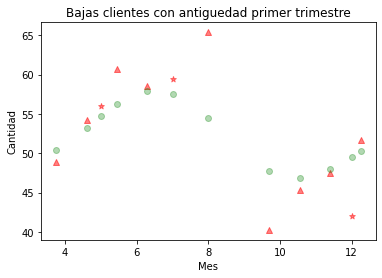

In [108]:
plt.scatter(x_valor, y_valor, c='red', marker='^', alpha=0.5)
plt.scatter(x_valor_t , y_valor_t , c='red', marker='*', alpha=0.5)
plt.scatter(x_valor, y_predic_valor, c='green', marker='o', alpha=0.3)
plt.scatter(x_valor_t , y_predic_valor_t , c='green', marker='o', alpha=0.3)
plt.xlabel('Mes')
plt.ylabel('Cantidad')
plt.title('Bajas clientes con antiguedad primer trimestre')
plt.show()

In [109]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVR
# 2trim
#entrenamos datos
x1 = X[:,0]
x1 = x1[:,np.newaxis]
y1 = X[:,2]
y1 = y1[:,np.newaxis]

x_train, x_test, y_train, y_test = train_test_split(x1, y1,train_size = 0.8,
                                        random_state = 0,
                                        shuffle      = True
                                    )
#escalamos los datos
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
sc_y = StandardScaler()
x_train = sc_x.fit_transform(x_train)
y_train= sc_y.fit_transform(y_train)
x_test = sc_x.fit_transform(x_test)
y_test= sc_y.fit_transform(y_test)

#aplicando modelo svm
svr= SVR(kernel='rbf',degree=3, C=1.0, epsilon=0.2)
svr.fit(x_train,y_train)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [110]:
x_valor=sc_x.inverse_transform(x_train)
y_valor= sc_y.inverse_transform(y_train)
y_predic_valor= sc_y.inverse_transform(svr.predict(x_train))
y_predic_valor

array([19.94370716, 30.29522186, 19.94087763, 27.87820892, 22.9412778 ,
       19.02316963, 32.39208442, 26.15923863, 30.96926816])

In [111]:
y_valor

array([[22.20528809],
       [32.56450705],
       [22.20528809],
       [21.16936619],
       [20.1334443 ],
       [13.91791292],
       [31.52858515],
       [28.42081946],
       [55.35478875]])

In [112]:
x_valor_t=sc_x.inverse_transform(x_test)
y_valor_t= sc_y.inverse_transform(y_test)
y_predic_valor_t= sc_y.inverse_transform(svr.predict(x_test))
y_predic_valor_t

array([32.94433635, 19.53276045, 28.97406907])

In [113]:
y_valor_t

array([[43.5],
       [19. ],
       [20. ]])

In [114]:
#score
print(svr.score(x_train,y_train))
print(svr.score(x_test,y_test))

0.3976054640390204
0.5000265682179867


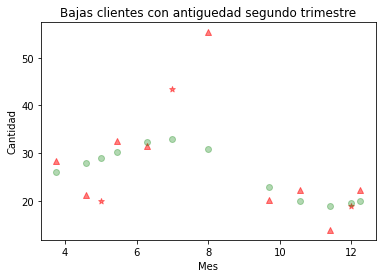

In [115]:
plt.scatter(x_valor, y_valor, c='red', marker='^', alpha=0.5)
plt.scatter(x_valor_t , y_valor_t , c='red', marker='*', alpha=0.5)
plt.scatter(x_valor, y_predic_valor, c='green', marker='o', alpha=0.3)
plt.scatter(x_valor_t , y_predic_valor_t , c='green', marker='o', alpha=0.3)
plt.xlabel('Mes')
plt.ylabel('Cantidad')
plt.title('Bajas clientes con antiguedad segundo trimestre')
plt.show()

In [116]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVR
# 3trim
#entrenamos datos
x1 = X[:,0]
x1 = x1[:,np.newaxis]
y1 = X[:,3]
y1 = y1[:,np.newaxis]

x_train, x_test, y_train, y_test = train_test_split(x1, y1,train_size = 0.8,
                                        random_state = 0,
                                        shuffle      = True
                                    )
#escalamos los datos
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
sc_y = StandardScaler()
x_train = sc_x.fit_transform(x_train)
y_train= sc_y.fit_transform(y_train)
x_test = sc_x.fit_transform(x_test)
y_test= sc_y.fit_transform(y_test)

#aplicando modelo svm
svr= SVR(kernel='rbf',degree=3, C=1.0, epsilon=0.2)
svr.fit(x_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [117]:
x_valor=sc_x.inverse_transform(x_train)
y_valor= sc_y.inverse_transform(y_train)
y_predic_valor= sc_y.inverse_transform(svr.predict(x_train))
y_predic_valor

array([20.88754881, 24.03169029, 18.97816815, 23.59598356, 19.15018481,
       19.69161477, 23.769735  , 22.68474567, 21.53820839])

In [118]:
y_valor

array([[21.90259505],
       [25.01937219],
       [19.40917333],
       [33.74634819],
       [18.16246248],
       [15.66904076],
       [18.7858179 ],
       [21.27923962],
       [22.52595048]])

In [119]:
x_valor_t=sc_x.inverse_transform(x_test)
y_valor_t= sc_y.inverse_transform(y_test)
y_predic_valor_t= sc_y.inverse_transform(svr.predict(x_test))
y_predic_valor_t

array([23.06223074, 20.52321527, 23.88059265])

In [120]:
y_valor_t

array([[26.5],
       [15. ],
       [24. ]])

In [121]:
#score
print(svr.score(x_train,y_train))
print(svr.score(x_test,y_test))

0.3158600886344043
0.4213427439901445


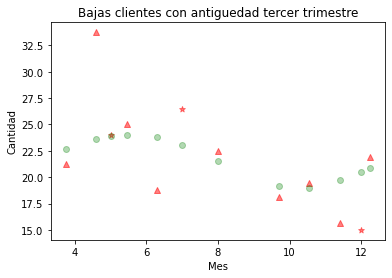

In [122]:
plt.scatter(x_valor, y_valor, c='red', marker='^', alpha=0.5)
plt.scatter(x_valor_t , y_valor_t , c='red', marker='*', alpha=0.5)
plt.scatter(x_valor, y_predic_valor, c='green', marker='o', alpha=0.3)
plt.scatter(x_valor_t , y_predic_valor_t , c='green', marker='o', alpha=0.3)
plt.xlabel('Mes')
plt.ylabel('Cantidad')
plt.title('Bajas clientes con antiguedad tercer trimestre')
plt.show()

In [123]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVR
# 4trim
#entrenamos datos
x1 = X[:,0]
x1 = x1[:,np.newaxis]
y1 = X[:,4]
y1 = y1[:,np.newaxis]

x_train, x_test, y_train, y_test = train_test_split(x1, y1,train_size = 0.8,
                                        random_state = 0,
                                        shuffle      = True
                                    )
#escalamos los datos
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
sc_y = StandardScaler()
x_train = sc_x.fit_transform(x_train)
y_train= sc_y.fit_transform(y_train)
x_test = sc_x.fit_transform(x_test)
y_test= sc_y.fit_transform(y_test)

#aplicando modelo svm
svr= SVR(kernel='rbf',degree=3, C=1.0, epsilon=0.2)
svr.fit(x_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [125]:
x_valor=sc_x.inverse_transform(x_train)
y_valor= sc_y.inverse_transform(y_train)
y_predic_valor= sc_y.inverse_transform(svr.predict(x_train))
y_predic_valor

array([172.08780082, 189.18063933, 171.82118772, 194.20389524,
       173.00021927, 171.31126043, 183.24734395, 196.31317856,
       175.73826878])

In [126]:
y_valor

array([[172.60601932],
       [192.18093351],
       [170.11672387],
       [215.60294066],
       [176.00051311],
       [168.30632719],
       [177.01886125],
       [199.30937047],
       [177.35831063]])

In [127]:
x_valor_t=sc_x.inverse_transform(x_test)
y_valor_t= sc_y.inverse_transform(y_test)
y_predic_valor_t= sc_y.inverse_transform(svr.predict(x_test))
y_predic_valor_t

array([179.20500144, 171.71550735, 192.10781363])

In [128]:
y_valor_t

array([[166. ],
       [181. ],
       [202.5]])

In [129]:
#score
print(svr.score(x_train,y_train))
print(svr.score(x_test,y_test))

0.7333390727150095
0.4524812016945418


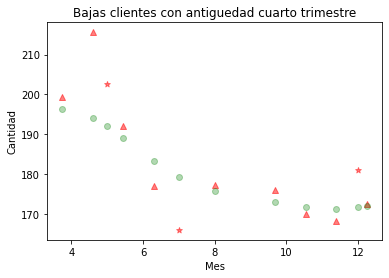

In [131]:
plt.scatter(x_valor, y_valor, c='red', marker='^', alpha=0.5)
plt.scatter(x_valor_t , y_valor_t , c='red', marker='*', alpha=0.5)
plt.scatter(x_valor, y_predic_valor, c='green', marker='o', alpha=0.3)
plt.scatter(x_valor_t , y_predic_valor_t , c='green', marker='o', alpha=0.3)
plt.xlabel('Mes')
plt.ylabel('Cantidad')
plt.title('Bajas clientes con antiguedad cuarto trimestre')
plt.show()